In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
# !pip install captum

In [4]:
# Run this first in a separate cell:
# !pip install timm --quiet

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from timm.models.vision_transformer import vit_base_patch16_224
import os
from captum.attr import LayerGradCam, IntegratedGradients


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [5]:
# --------------------------------------------------
# 1. MODEL (CNN-only for Grad-CAM, full model for predictions)
# --------------------------------------------------
class HighPerfNestedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # CNN branch only (for Grad-CAM)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.cnn_fc = nn.Linear(256, 256)
        
        # ViT branch
        self.vit = vit_base_patch16_224(pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, 256)
        
        # Fusion
        self.gate = nn.Sequential(nn.Linear(512, 256), nn.Sigmoid())
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x, return_cnn_features=False):
        # Auto-resize
        if x.shape[-2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        
        # CNN features
        cnn_features = self.cnn(x)
        x_cnn = self.global_pool(cnn_features).flatten(1)
        x_cnn = self.cnn_fc(x_cnn)
        
        # ViT
        x_vit = self.vit(x)
        
        # Fusion
        gate = self.gate(torch.cat([x_cnn, x_vit], dim=1))
        fused = gate * x_cnn + (1 - gate) * x_vit
        
        out = self.classifier(fused)
        return (out, cnn_features) if return_cnn_features else out


In [6]:
# --------------------------------------------------
# 2. MANUAL GRAD-CAM++ (full control, no magic)
# --------------------------------------------------
class ManualGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Register hooks
        self.fwd_hook = target_layer.register_forward_hook(self._save_activation)
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        self.activations = output.detach().cpu()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach().cpu()
    
    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()
    
    def generate(self, input_tensor, target_class):
        # Forward with CNN features
        self.model.zero_grad()
        output, cnn_feat = self.model(input_tensor, return_cnn_features=True)
        
        # Backward
        output[0, target_class].backward(retain_graph=False)
        
        # Get CAM
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # Interpolate
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam

In [7]:
# --------------------------------------------------
# 3. SETUP
# --------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/kaggle/input/highperf-nested-model/pytorch/default/1/best_highperf_nested_model.pth"

model = HighPerfNestedModel(num_classes=4).to(device)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

HighPerfNestedModel(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [8]:
# --------------------------------------------------
# 4. IMAGE PATHS
# --------------------------------------------------
# DATASET_ROOT = "/kaggle/input/brain-tumor-mri-dataset/Testing"
# class_names = ["glioma", "meningioma", "pituitary"]
# img_paths = [
#     "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0009.jpg",
#     "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0009.jpg",
#     "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0009.jpg"
# ]

import os
import random

# Dataset root and classes
DATASET_ROOT = "/kaggle/input/brain-tumor-mri-dataset/Testing"
class_names = ["glioma", "meningioma", "pituitary"]

# List to store random image paths
img_paths = [
    "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0040.jpg",
    "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0036.jpg",
    "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0013.jpg"
]

# for cls in class_names:
#     dir_path = os.path.join(DATASET_ROOT, cls)
#     # Get all image files in the folder
#     files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
#     # Choose 1 random image from this class
#     img_paths.append(os.path.join(dir_path, random.choice(files)))

# # Now img_paths contains 3 random images, one from each class
# print(img_paths)


for cls in class_names:
    dir_path = os.path.join(DATASET_ROOT, cls)
    files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    img_paths.append(os.path.join(dir_path, files[0]))

In [9]:
# --------------------------------------------------
# 5. TRANSFORMS
# --------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
])


Processing: GLIOMA
Prediction: class 3 | Confidence: 0.917
✓ Grad-CAM generated: shape=(224, 224), range=[0.0000, 1.0000]

Processing: MENINGIOMA
Prediction: class 0 | Confidence: 0.928
✓ Grad-CAM generated: shape=(224, 224), range=[0.0000, 1.0000]

Processing: PITUITARY
Prediction: class 1 | Confidence: 0.928
✓ Grad-CAM generated: shape=(224, 224), range=[0.0000, 1.0000]


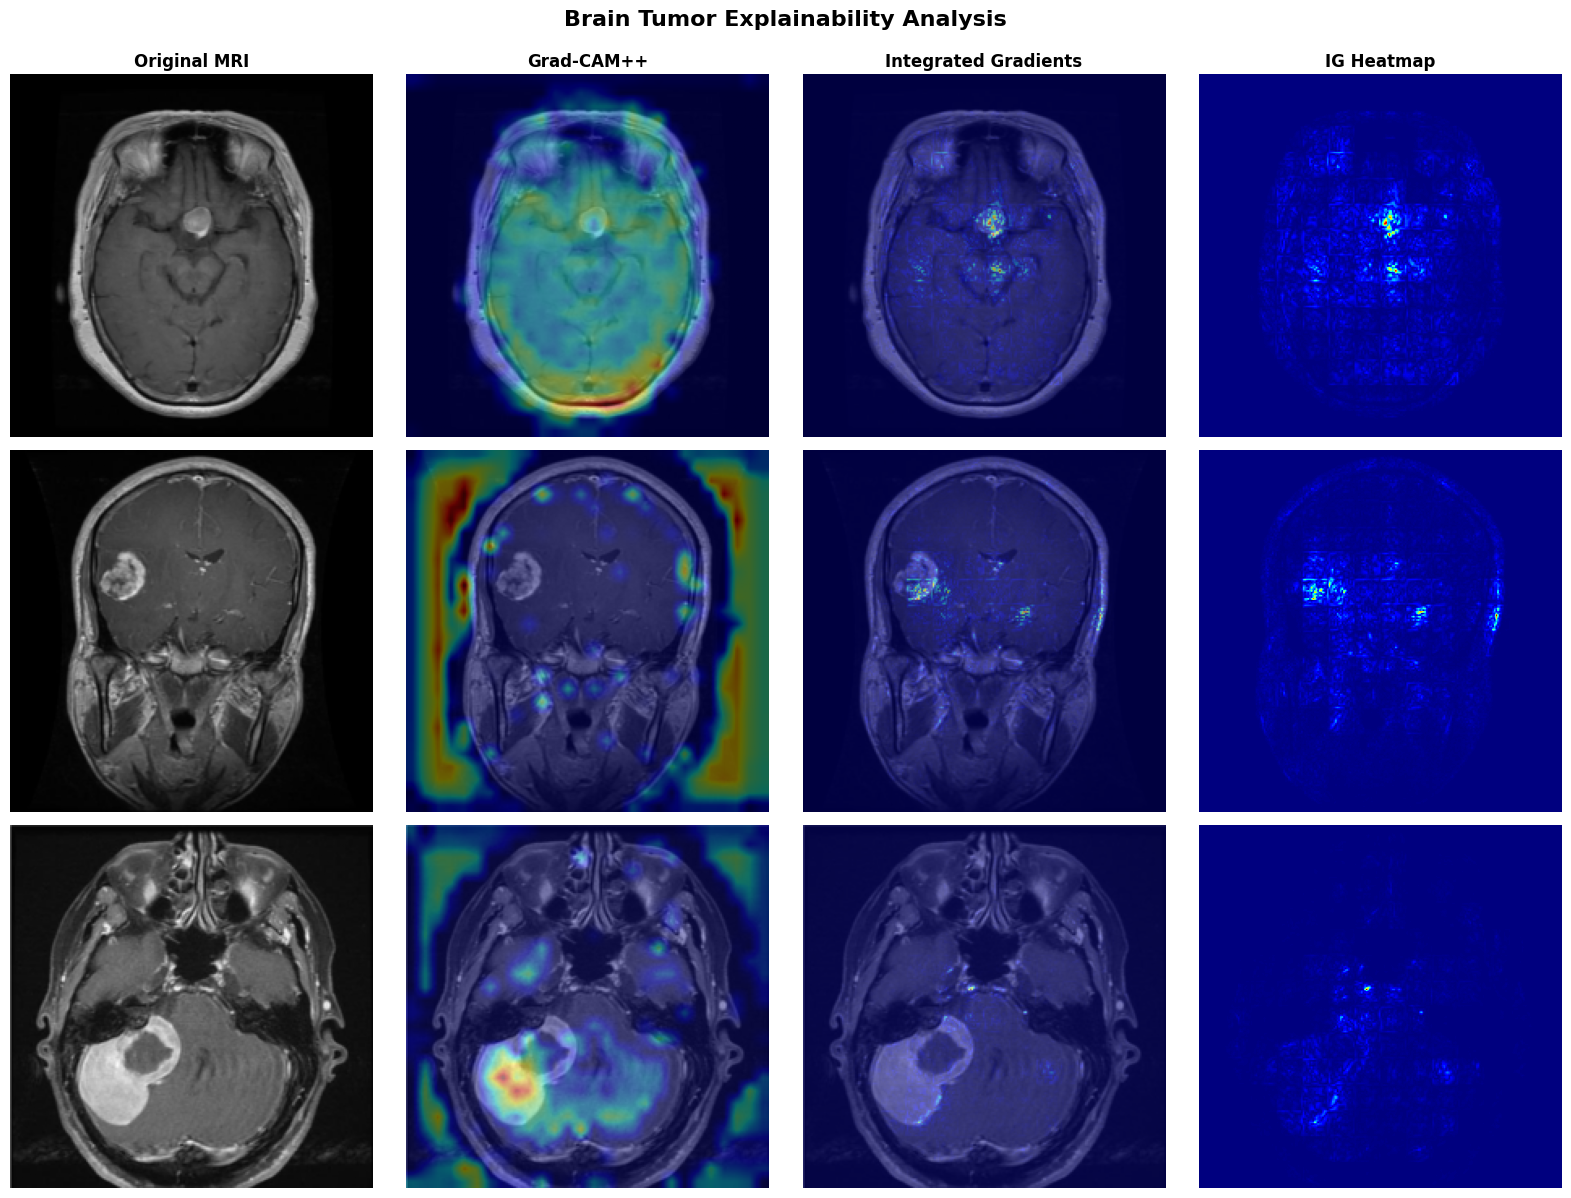


✅ COMPLETE!


In [10]:
# --------------------------------------------------
# 6. EXECUTION WITH GRADIENT DEBUGGING
# --------------------------------------------------
fig, axes = plt.subplots(len(class_names), 4, figsize=(16, 12))

for i, (path, name) in enumerate(zip(img_paths, class_names)):
    
    # Load image
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    img_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0, pred].item()
    print(f"Prediction: class {pred} | Confidence: {confidence:.3f}")
    
    # 1. Original
    axes[i, 0].imshow(img_np)
    axes[i, 0].axis("off")
    axes[i, 0].set_ylabel(f"{name}\n(conf: {confidence:.2f})", rotation=90, size=11, fontweight='bold')
    
    # 2. Manual Grad-CAM (FIXED)
    target_layer = model.cnn[-1]  # The ReLU layer after last Conv2d
    gradcam = ManualGradCAM(model, target_layer)
    
    try:
        cam = gradcam.generate(input_tensor, pred)
        print(f"Grad-CAM generated: shape={cam.shape}, range=[{cam.min():.4f}, {cam.max():.4f}]")
    except Exception as e:
        print(f"Grad-CAM failed: {e}")
        cam = np.ones((224, 224)) * 0.5  # Fallback
    
    gradcam.remove_hooks()
    
    # FIX: Better overlay to ensure visibility
    overlay = np.uint8(plt.cm.jet(cam)[..., :3] * 255)
    img_uint8 = np.uint8(img_np * 255)
    blended = cv2.addWeighted(img_uint8, 0.6, overlay, 0.4, 0) if 'cv2' in globals() else img_np * 0.6 + plt.cm.jet(cam)[..., :3] * 0.4
    axes[i, 1].imshow(blended)
    axes[i, 1].axis("off")
    
    # 3. Integrated Gradients (simplified)
    baseline = torch.zeros_like(input_tensor)
    ig = IntegratedGradients(model)
    
    # FIX: Reduce steps for stability
    attr_ig = ig.attribute(input_tensor, baselines=baseline, target=pred, n_steps=30)
    attr_np = attr_ig.squeeze().abs().cpu().numpy()
    attr_combined = np.max(attr_np, axis=0)
    attr_combined = (attr_combined - attr_combined.min()) / (attr_combined.max() - attr_combined.min() + 1e-8)
    
    axes[i, 2].imshow(img_np * 0.5 + plt.cm.jet(attr_combined)[..., :3] * 0.5)
    axes[i, 2].axis("off")
    
    # 4. IG Heatmap
    axes[i, 3].imshow(attr_combined, cmap='jet')
    axes[i, 3].axis("off")

# Add titles
titles = ["Original MRI", "Grad-CAM++", "Integrated Gradients", "IG Heatmap"]
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=12, fontweight='bold')

plt.suptitle("Brain Tumor Explainability Analysis", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('brain_tumor_explainability.png', dpi=150, bbox_inches='tight')
plt.show()